# ICE 2: Handwritten Digits - DNN

This notebook demonstrates the building and training of a deep neural network (DNN) for digit classification using the `load_digits` dataset from scikit-learn. The DNN is built using TensorFlow's Keras API.

## Pre-Reading

- Video [3Blue1Brown: But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk)

### Objectives

- Understand the types of layers in a Neural Network and how they can be modified.
- Describe TensorFlow and Keras at a conceptual level
- Get a model for classifying handwritten digits

This notebook is a modification of Chollet's, [*Deep Learning with Python*, 2.1 A first look at a neural network](https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/Text/02.htm#:-:text=2.1%20A%20first%20look%20at%20a%20neural%20network) [GitHub notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter02_mathematical-building-blocks.ipynb)
with a few additions from [TensorFlow Tutorials](https://www.tensorflow.org/tutorials/images/transfer_learning).

In [24]:
# Google colab includes by default, so you probably won't need to run
%pip install -q matplotlib scikit-learn

In [25]:
import tensorflow as tf

print("Running Tensorflow version", tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name == "/device:GPU:0":
    print(f"Using GPU: {device_name}")
else:
    print("No GPU detected; running on CPU.")

Running Tensorflow version 2.17.1
No GPU detected; running on CPU.


## The Dataset

We will use the same handwritten digits dataset we used with K-Means.

The MNIST dataset comes preloaded in Keras, in the form of a set of four **train** and **test** NumPy arrays.

In [26]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

Visualize the dataset

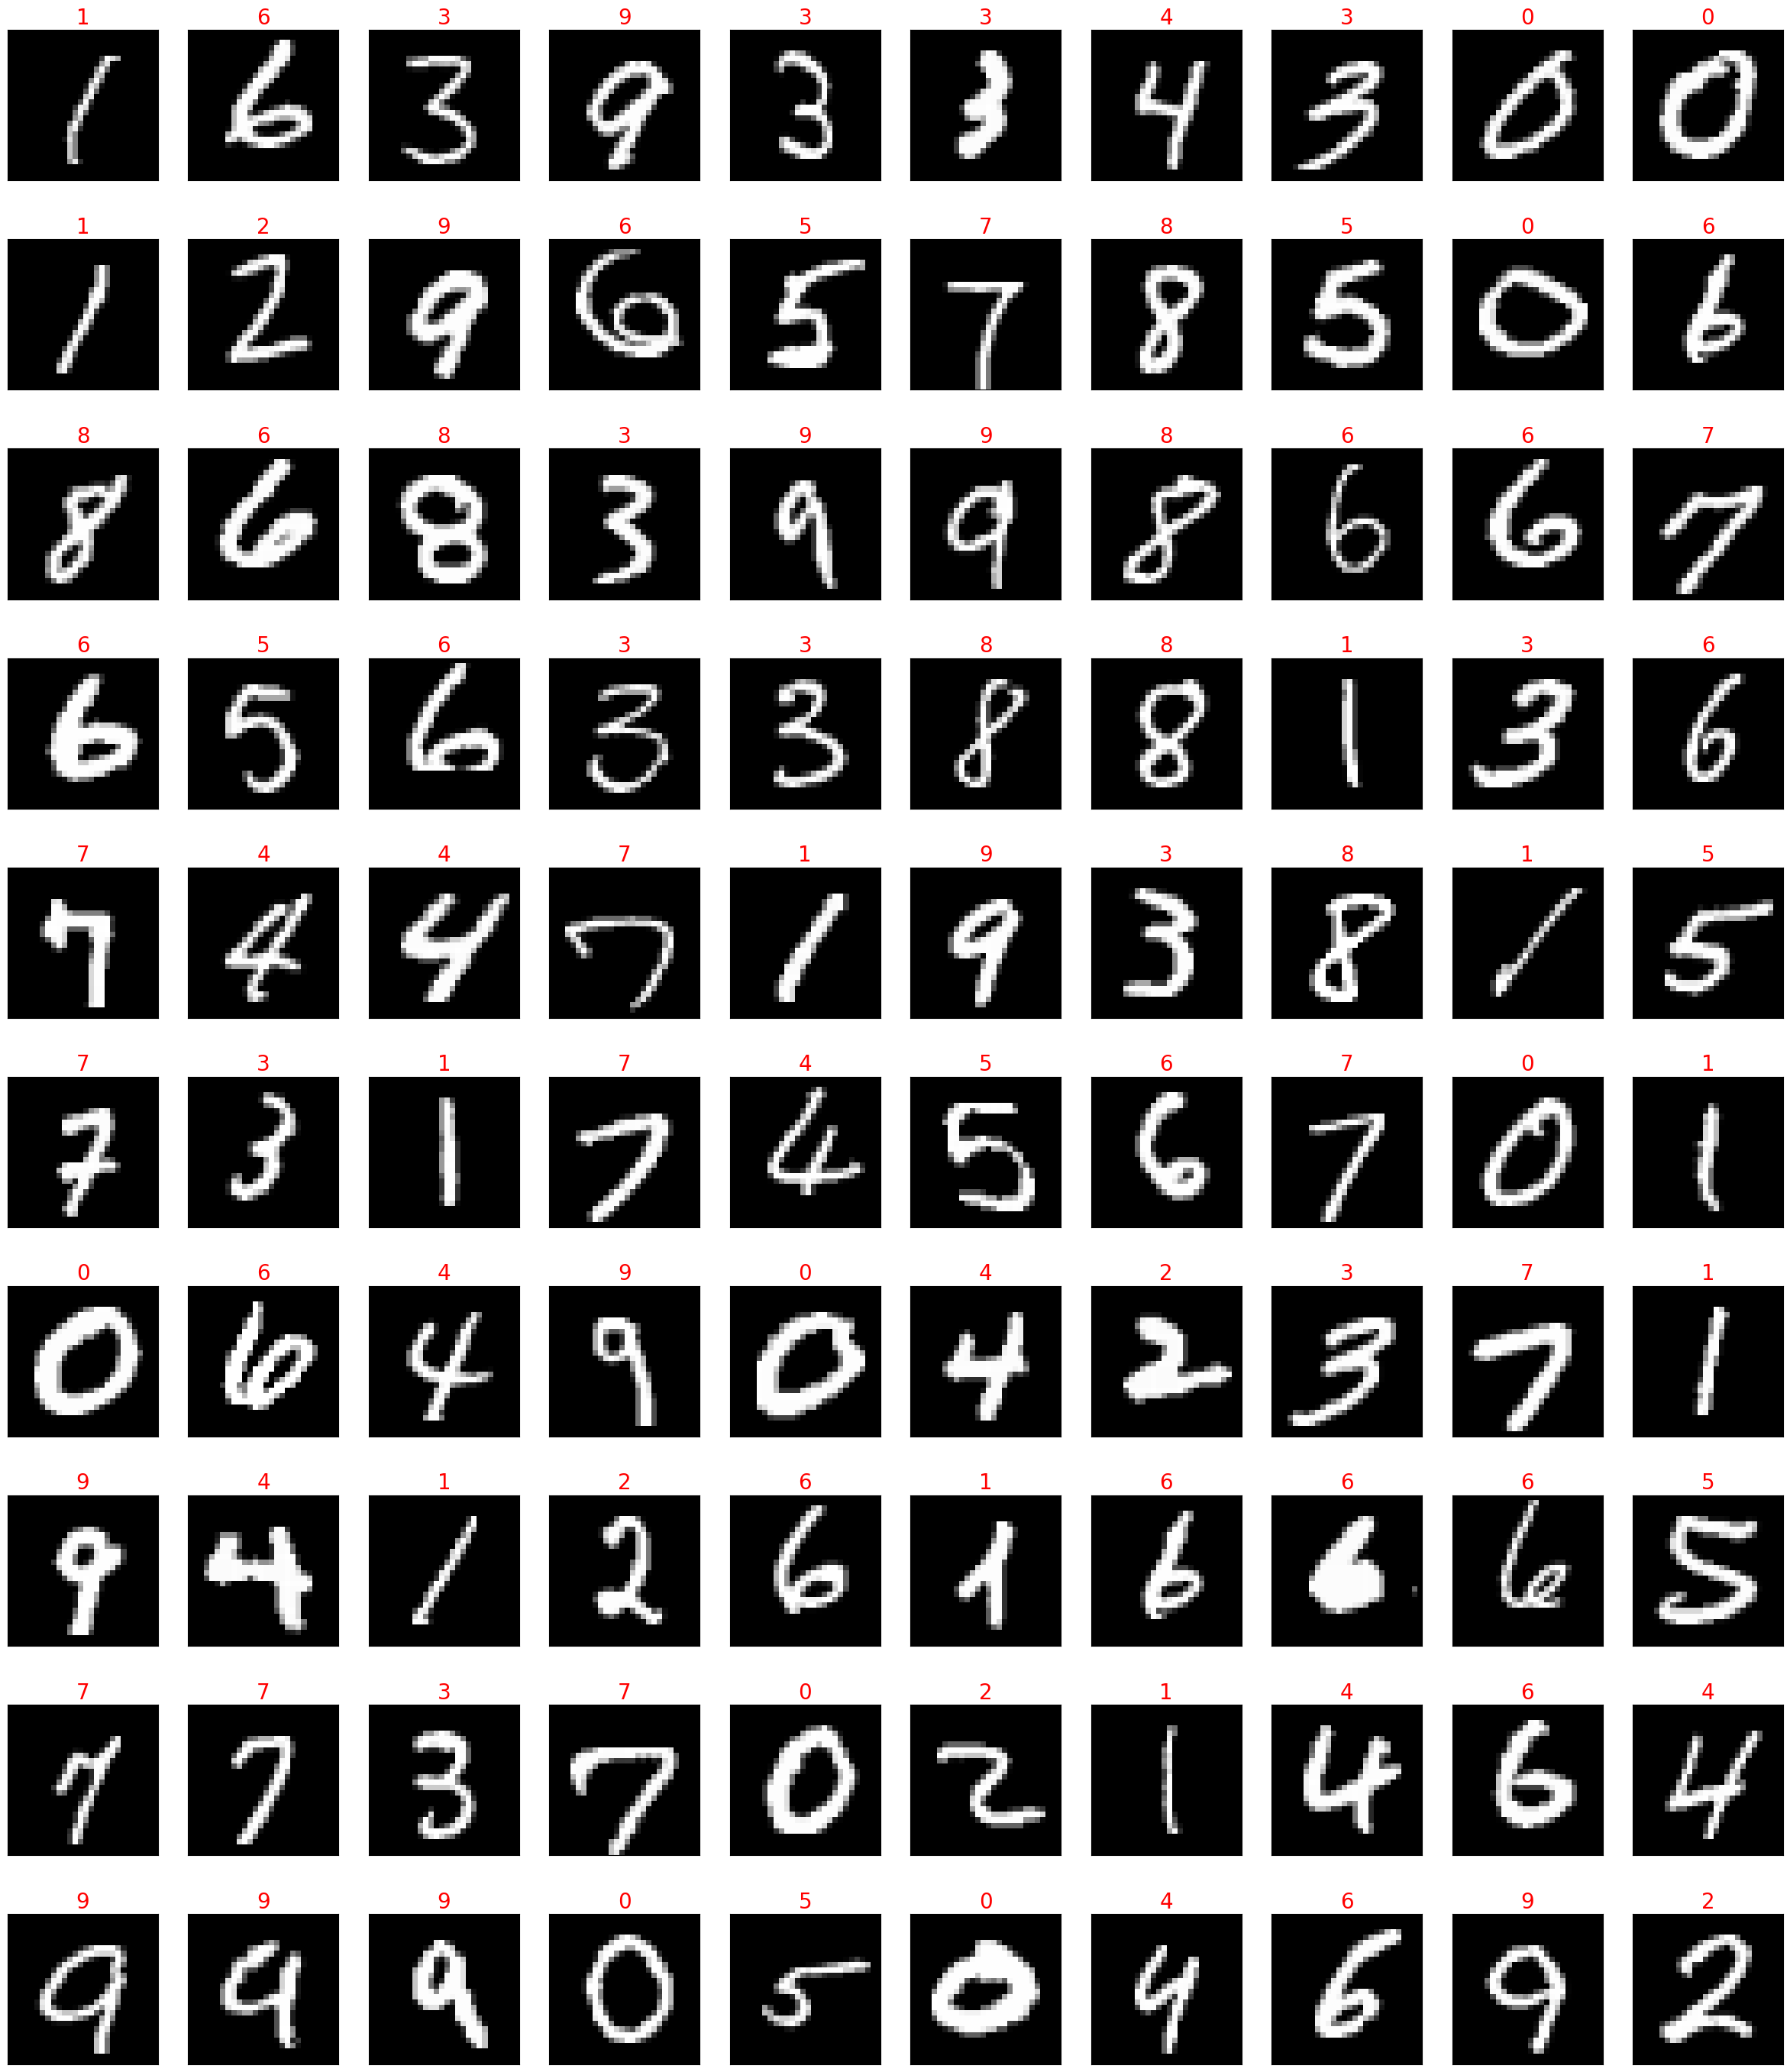

In [27]:
import numpy as np
import matplotlib.pyplot as plt


def show_images():
    """Show 100 random images from the dataset"""
    array = np.random.randint(low=1, high=10000, size=100)
    fig = plt.figure(figsize=(30, 35))
    for i in range(100):
        fig.add_subplot(10, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(train_labels[array[i]], color="red", fontsize=20)
        plt.imshow(train_images[array[i]], cmap="gray")


show_images()

### Set Splitting

The dataset already comes split into two sets:

- **train** is the set we will fit the model to
- **test** is the set we will evaluate the model against

In the upcoming Lab we will want to use this model to predict on digits *we* create!

To do this we'll need to pass the network *exactly* the same shape tensor of the appropriate type.

In [28]:
# TODO: replace None with `type` function call on train_images
# Upload the output of this cell to Gradescope
print("Type model expects:", type(train_images))

Type model expects: <class 'numpy.ndarray'>


In [29]:
# TODO: replace None with `ndim` attribute of train_images
# Upload the output of this cell to Gradescope
print("Dimensions model expects:", train_images.ndim)

Dimensions model expects: 3


It's also **extremely** helpful to know the shape of the training dataset.
The first axis will be how many samples, the next axes will be how many features per axis... in this case, pixels!

In [30]:
# TODO: print the shape of train_images
print("Shape of Train Images:", train_images.shape)

Shape of Train Images: (60000, 28, 28)


What about the labels for the train set? How many and what's their type?

In [31]:
len(train_labels)

60000

In [32]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

How many samples are in the test set?

In [33]:
len(test_labels)

10000

#### Validation Set

To monitor overfitting, we will break out a *validation set* from out training set using scikit-learn [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

We will use `stratify` to make sure that the validation set contains a balanced representation of the labels present in the training set.

In [34]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.15, random_state=37, stratify=train_labels
)

In [35]:
print(
    f"After split: train_images: {train_images.shape}, val_images: {val_images.shape}"
)

After split: train_images: (51000, 28, 28), val_images: (9000, 28, 28)


## Build the Deep Neural Network

We are going to build a deep(ish) neural network, remember that you aren’t expected to understand everything about this example yet.
Layers get added into the model one at a time (sequential).

The core building block of neural networks is the layer. You can think of a layer as a filter for data: some data goes in, and it comes out in a more useful form.

We will assemble our model as a series of [Keras sequential layers](https://keras.io/guides/sequential_model/)

> A `Sequential` model is appropriate for a plain stack of layers where each layer has **exactly one input tensor and one output tensor**.

Here is the layer breakdown.
The number and size of the hidden layers are arbitrarily chosen here... this is one of the greatest challenges in DNN.

- [**Input**](https://keras.io/api/layers/core_layers/input/) tells our model what shape tensor to expect as an input.
- [**Rescaling**](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/) preprocesses the pixel values from `[0, 255]` to `[0, 1]`, which helps prevent large values from skewing training.
- [**Flatten**](https://keras.io/api/layers/reshaping_layers/flatten/) converts the 2D matrix input to a 1D vector, which is needed because the upcoming dense layer expects the shape `(batch_size, input_dim)`.
- [**Dense**](https://keras.io/api/layers/core_layers/dense/) implements the operation: `output = activation(dot(input, kernel) + bias)`. We'll use [ReLU](https://keras.io/api/layers/activation_layers/relu/) (Rectified Linear Unit), which has the output `max(x, 0)`.
- [**Dropout**](https://keras.io/api/layers/regularization_layers/dropout/) randomly sets some input units to 0. This tends to help prevent *overfitting*.
- [**Softmax**](https://keras.io/api/layers/activation_layers/softmax/) converts a vector of K real numbers into a probability distribution of K possible outcomes.
The sum of these probabilities equals 1. We will assign our sample to the class with the highest probability.

In [36]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Input(shape=(28, 28)),
        layers.Rescaling(1.0 / 255),  # Normalize pixel values to [0, 1]
        layers.Flatten(),  # Flatten input
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.2),  # Regularization to prevent overfitting
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.2),  # Another regularization layer
        layers.Dense(10, activation="softmax"),
    ]
)

### Compile the Model

To make the model ready for training, we need to pick three more things as part of the compilation step:

- *Optimizer:* The mechanism through which the model will update itself based on the training data it sees, so as to improve its performance.
- *Loss function*: How the model will be able to measure its performance on the training data, and thus how it will be able to steer itself in the right direction.
- *Metrics*: to monitor during training and testing—Here, we’ll only care about accuracy (the fraction of the images that were correctly classified).

Keras provides the [compile](https://keras.io/api/models/model_training_apis/) API which does A LOT of stuff under the hood.

In [37]:
model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

#### Visualize the Model

We can print a summary of the model as well as a graphical represnetation.

We should always do this [for a few reasons:](https://machinelearningmastery.com/visualize-deep-learning-neural-network-model-keras/)

- **Confirm layer order**. It is easy to add layers in the wrong order with the sequential API or to connect them together incorrectly with the functional API. The graph plot can help you confirm that the model is connected the way you intended.
- **Confirm the output shape of each layer**. It is common to have problems when defining the shape of input data for complex networks like convolutional and recurrent neural networks. The summary and plot can help you confirm the input shape to the network is as you intended.
- **Confirm parameters**. Some network configurations can use far fewer parameters, such as the use of a TimeDistributed wrapped Dense layer in an Encoder-Decoder recurrent neural network. Reviewing the summary can help spot cases of using far more parameters than expected.

Our "Output Shape" is unknown because we didn't specify an Input Layer. Instead, we need to transform our data.


In [38]:
# You should ALWAYS run this after compile
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 535,818 (2.04 MB)

 Trainable params: 535,818 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

Keras offers a [fit](https://keras.io/api/models/model_training_apis/) API that will automatically train the model on our data for a set number of epochs.

Two quantities are displayed during training: the loss of the model over the training data, and the accuracy of the model over the training data.

Notice the accuracy increasing to over 98%.


In [39]:
history = model.fit(
    train_images,
    train_labels,
    epochs=10,
    batch_size=128,
    validation_data=(val_images, val_labels),
)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.8406 - loss: 0.5101 - val_accuracy: 0.9527 - val_loss: 0.1628
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.9612 - loss: 0.1280 - val_accuracy: 0.9649 - val_loss: 0.1121
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9743 - loss: 0.0828 - val_accuracy: 0.9736 - val_loss: 0.0862
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.9793 - loss: 0.0642 - val_accuracy: 0.9700 - val_loss: 0.1025
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9842 - loss: 0.0499 - val_accuracy: 0.9746 - val_loss: 0.0895
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9862 - loss: 0.0448 - val_accuracy: 0.9773 - val_loss: 0.0836
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.9890 - loss: 0.0346 - val_accuracy: 0.9788 - val_loss: 0.0794
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9916 - loss: 0.0280 - v

### Loss History

Let's plot the loss history.

Based on validation loss vs. training loss, do you think overfitting is occurring?

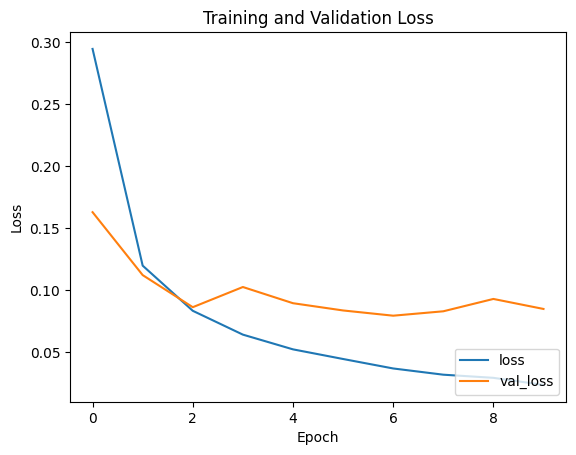

In [40]:
# A simple plot of training and validation loss over the epochs

plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.ylim([0, 1])
plt.legend(loc="lower right")

plt.show()

## Make a Prediction

Finally, we can evaluate the accuracy of the trained model on the validation set.

Now that we have a trained model, we can use it to predict class probabilities for new digits—images that weren’t part of the training data, like those from the test set.

In [41]:
# Grab the first samples from the test dataset
test_digits = test_images[0:5]

# Make prediction on that sample
prediction = model.predict(test_digits)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[1.7681984e-12 3.8826206e-11 5.1097476e-10 2.0320712e-10 1.1116770e-14
  6.6522627e-14 1.6449080e-15 1.0000000e+00 5.3192229e-12 1.5143103e-09]
 [2.3237770e-13 1.0422302e-07 9.9999988e-01 5.3641616e-09 9.5612163e-19
  1.8709515e-12 1.5705090e-13 1.6644507e-14 2.3016620e-11 3.2976067e-19]
 [4.3162158e-09 9.9992788e-01 7.3002006e-08 2.4031507e-10 3.1564956e-05
  5.2963531e-09 9.6833164e-09 3.9334132e-05 1.0105641e-06 3.2077491e-08]
 [9.9999487e-01 1.6723768e-09 6.5281546e-07 7.5539766e-08 6.2092532e-08
  1.6861527e-07 2.2714162e-06 5.7742269e-09 1.1652341e-08 1.7612878e-06]
 [3.0478169e-11 1.5693556e-10 2.1411808e-09 1.4710490e-13 9.9999034e-01
  2.7587406e-11 3.9328724e-10 3.2286803e-07 3.5519765e-10 9.2687278e-06]]


This is the output of the **softmax** layer.

The sum of probabilities for these 10 elements is 1.

Whichever class corresponds with the element that has highest probability is the class we predict.

In [42]:
highest_prediction_index = prediction[0].argmax()
print(
    "Index of highest probability:",
    highest_prediction_index,
    "with probability:",
    prediction[0][highest_prediction_index],
    "\nTrue label:",
    test_labels[0],
)

Index of highest probability: 7 with probability: 1.0 
True label: 7


Because index 7 has the highest probability (with over 99%), we predict that is the class.
The true label agrees!

And here is the image itself!

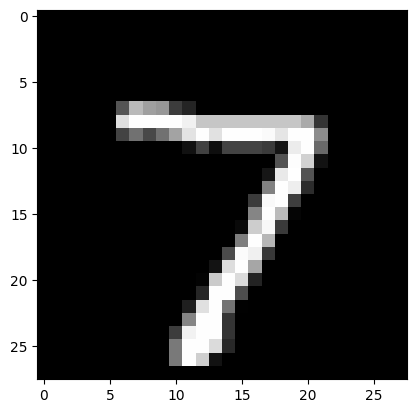

In [43]:
# Plot the first sample
plt.imshow(test_digits[0], cmap="gray")

### Overall Accuracy

On average, how good is our model at classifying such never-before-seen digits? Let’s check by computing average accuracy over the entire test set.

In [44]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"test_acc: {test_acc}")
print(f"test_loss: {test_loss}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9804 - loss: 0.0836
test_acc: 0.983299970626831
test_loss: 0.07126832753419876


The test set will have a lower accuracy than the training set, partyl because of overfitting. We will address that later.

## Save the Model

We need to re-use this model later.
Make sure to **download** the `digits.keras` file after you run this command!

In [46]:
# Download and keep this file after saving!
model.save("digits.keras")

## Deliverables

Submit the following to the Gradescope ICE 2 assignment:

- The type and shape outputs
- Your Keras model
- This completed notebook